<a href="https://colab.research.google.com/github/Mayan-Ryan/ECG-Arrythmia/blob/main/MITBIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manavtaluja","key":"bcf91617b5ae9f8e88066971bf42e398"}'}

In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Sep 21 05:25 kaggle.json


In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d taejoongyoon/mitbit-arrhythmia-database

 97% 281M/288M [00:05<00:00, 38.1MB/s]
100% 288M/288M [00:05<00:00, 50.9MB/s]


In [6]:
!unzip mitbit-arrhythmia-database.zip

Archive:  mitbit-arrhythmia-database.zip
  inflating: mitbih_database/100.csv  
  inflating: mitbih_database/100annotations.txt  
  inflating: mitbih_database/101.csv  
  inflating: mitbih_database/101annotations.txt  
  inflating: mitbih_database/102.csv  
  inflating: mitbih_database/102annotations.txt  
  inflating: mitbih_database/103.csv  
  inflating: mitbih_database/103annotations.txt  
  inflating: mitbih_database/104.csv  
  inflating: mitbih_database/104annotations.txt  
  inflating: mitbih_database/105.csv  
  inflating: mitbih_database/105annotations.txt  
  inflating: mitbih_database/106.csv  
  inflating: mitbih_database/106annotations.txt  
  inflating: mitbih_database/107.csv  
  inflating: mitbih_database/107annotations.txt  
  inflating: mitbih_database/108.csv  
  inflating: mitbih_database/108annotations.txt  
  inflating: mitbih_database/109.csv  
  inflating: mitbih_database/109annotations.txt  
  inflating: mitbih_database/111.csv  
  inflating: mitbih_database/1

## Reading files from the dataset

In [4]:
import os
import pywt
import csv
import itertools
import collections
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
from cycler import cycler

In [5]:
# modify the runtime configuration settings of matplotlib
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])
plt.rcParams['axes.grid'] = True 

In [6]:
# create two files to store csv records and annotations
path = '/content/mitbih_database/'
filenames = next(os.walk(path))[2]
filenames.sort()
records = list()
annotations = list()
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    else:
        annotations.append(path + filename + file_extension)

In [7]:
records[0]

'/content/mitbih_database/100.csv'

In [8]:
annotations[0]

'/content/mitbih_database/100annotations.txt'

In [9]:
# create a function to denoise the ECG signals
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    z = pywt.waverec(coeffs, 'sym4')
    
    return z

## Plotting Signals

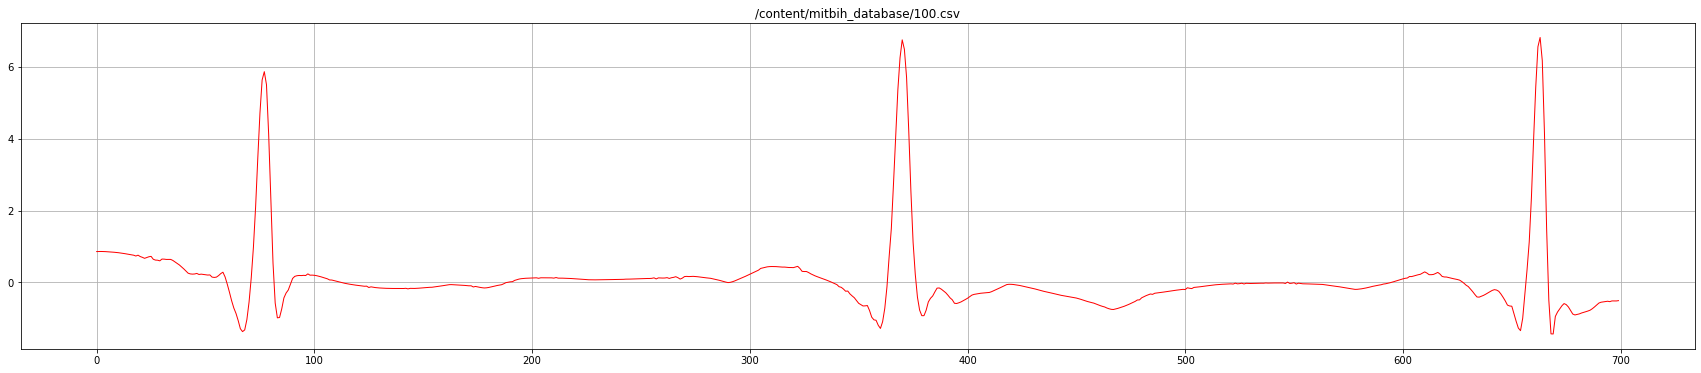

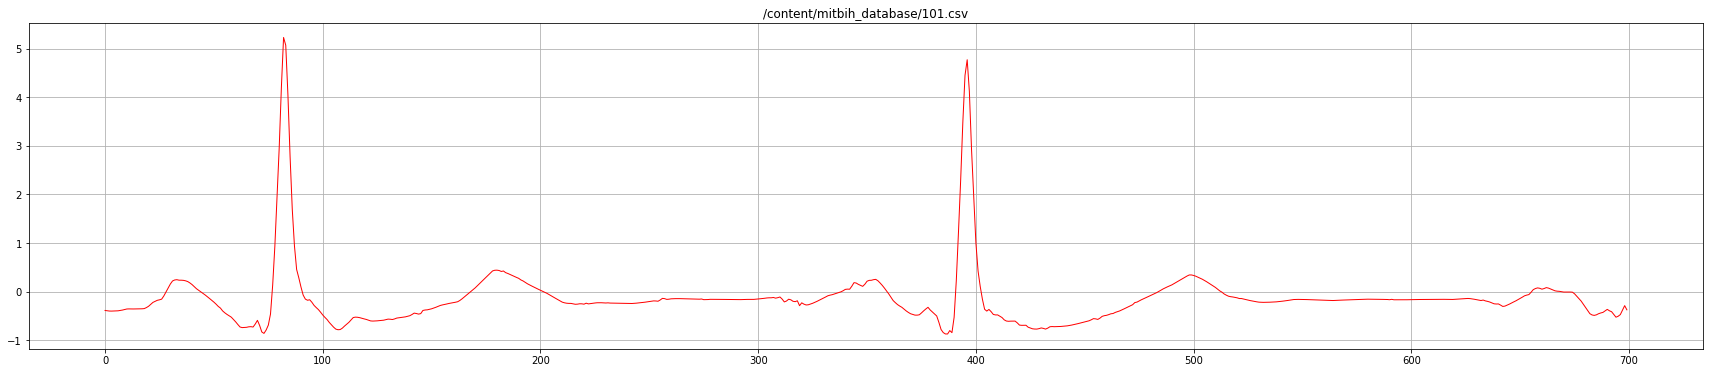

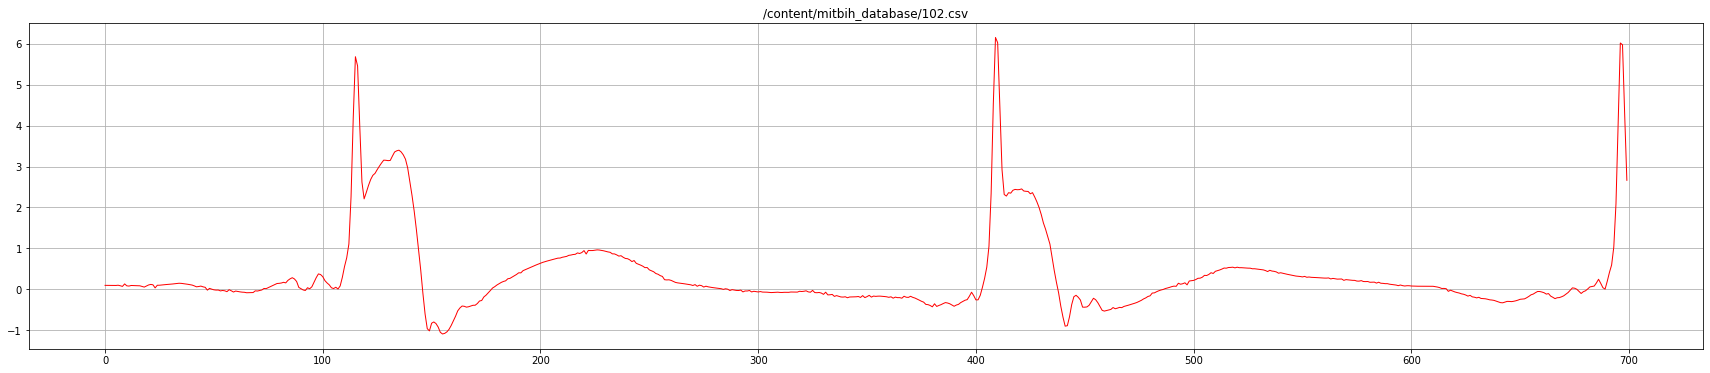

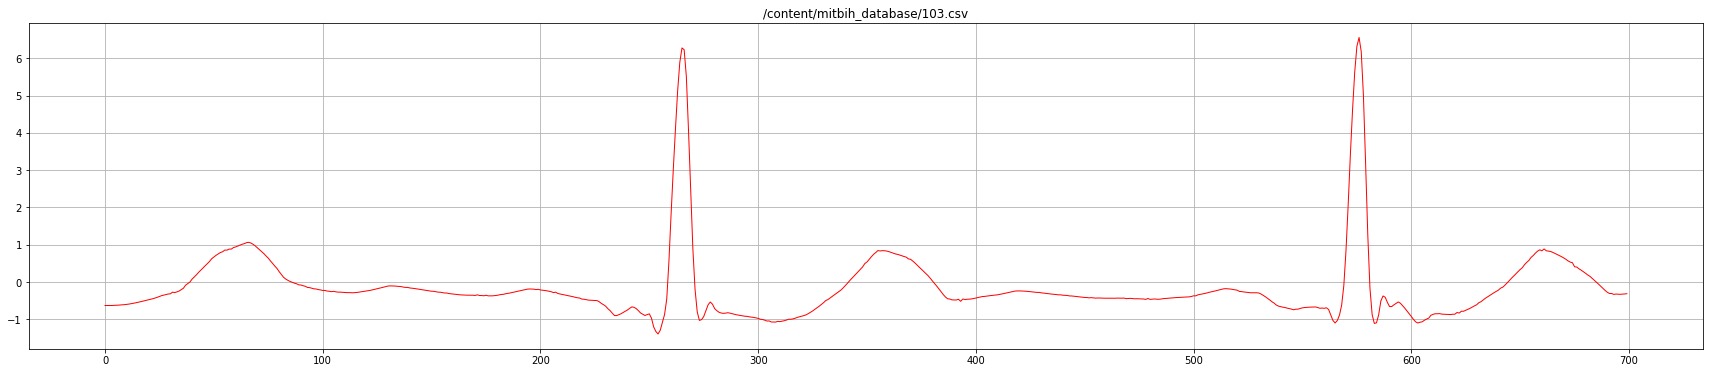

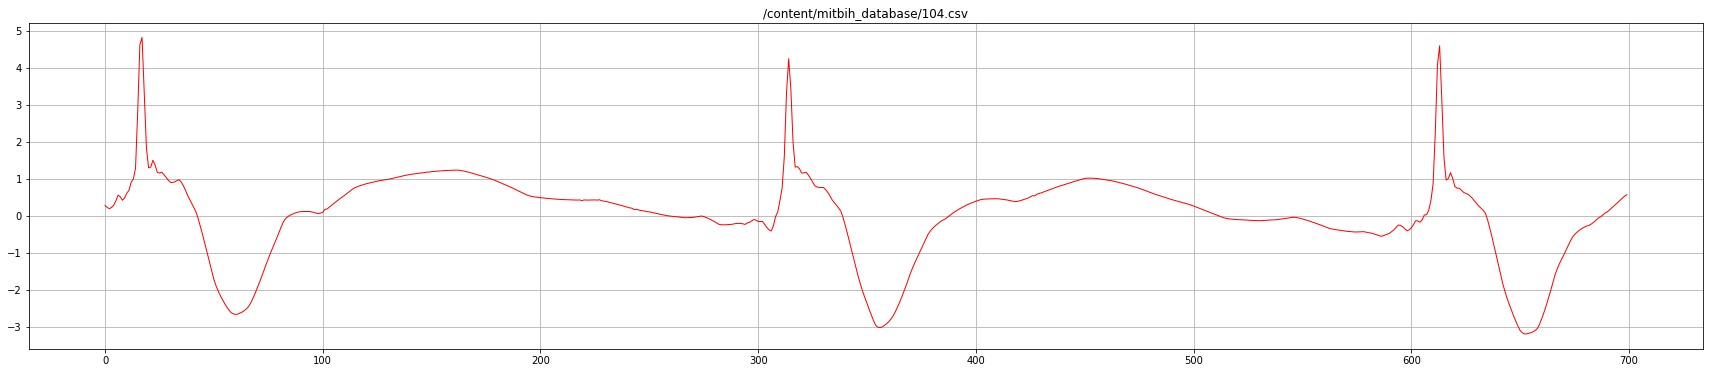

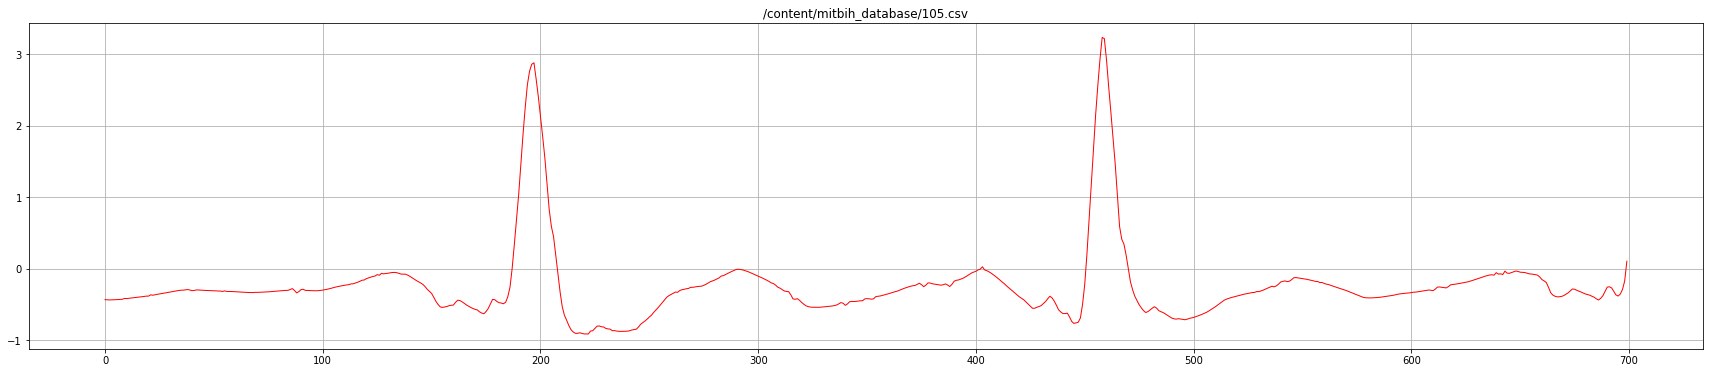

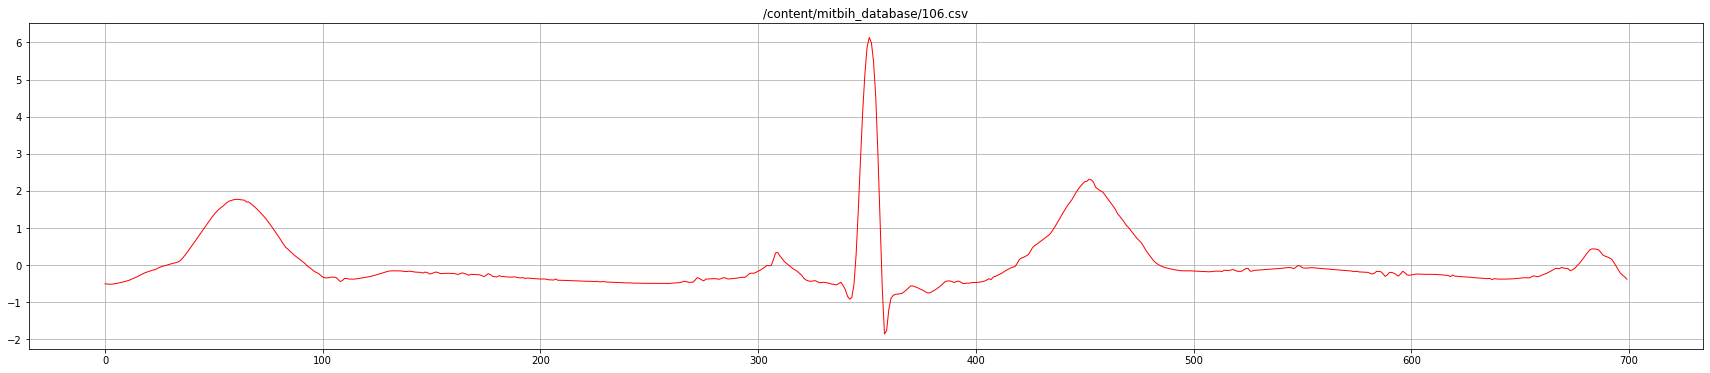

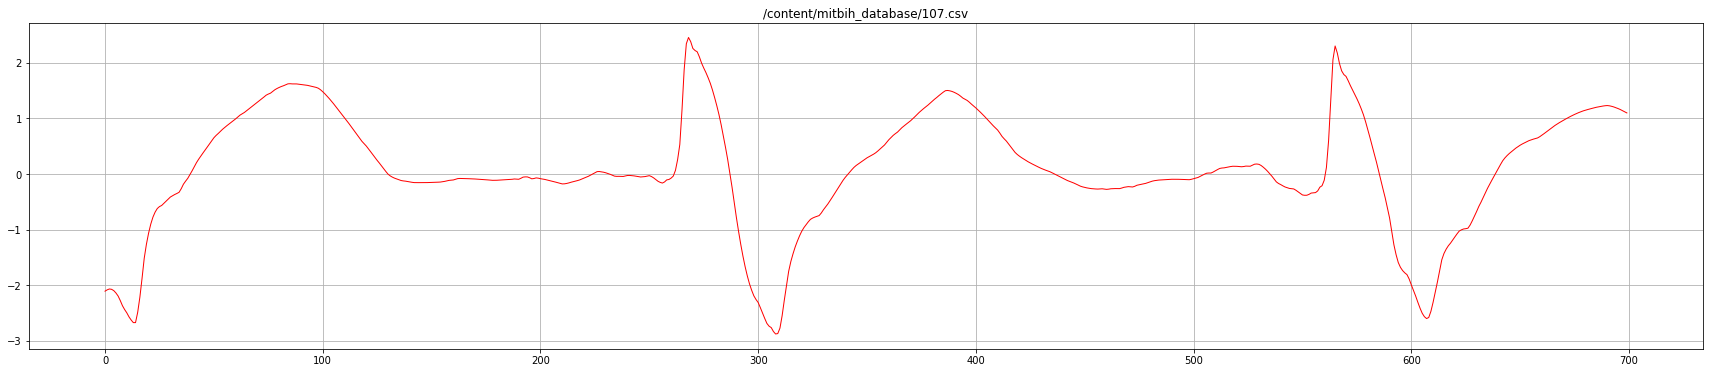

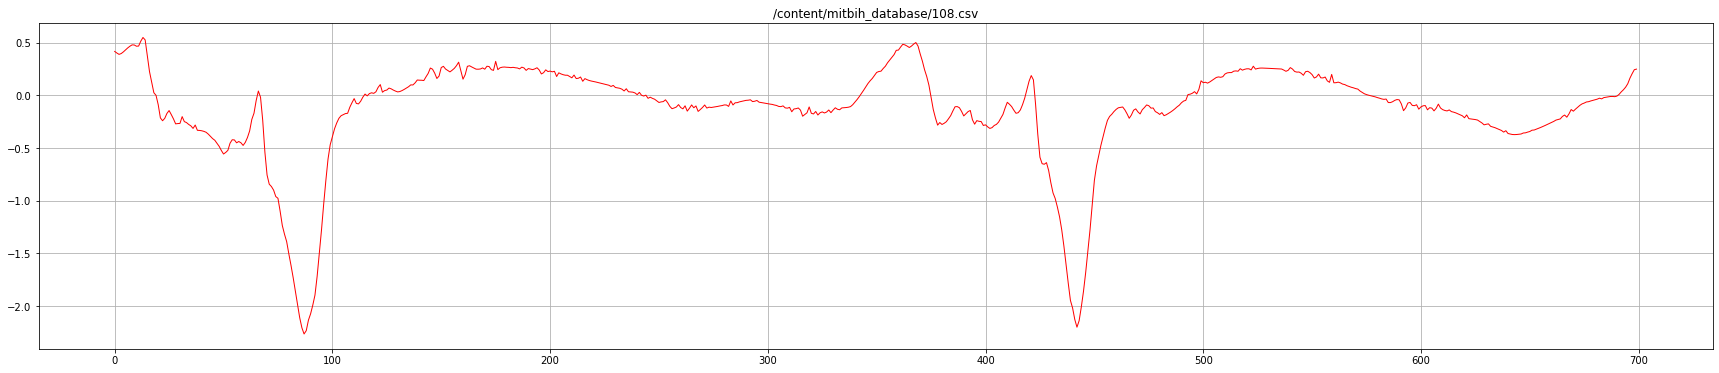

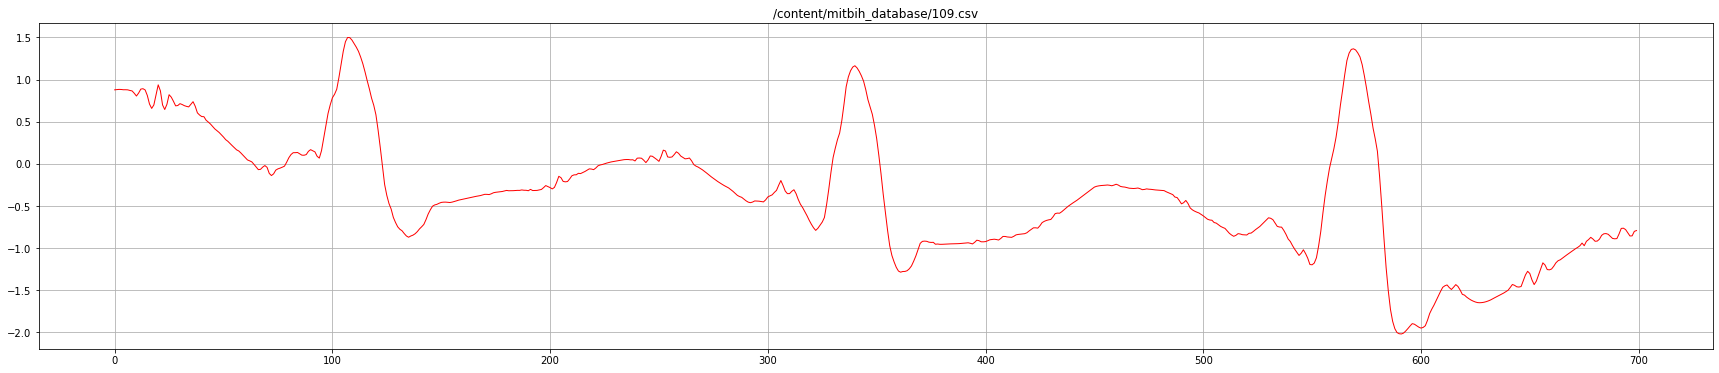

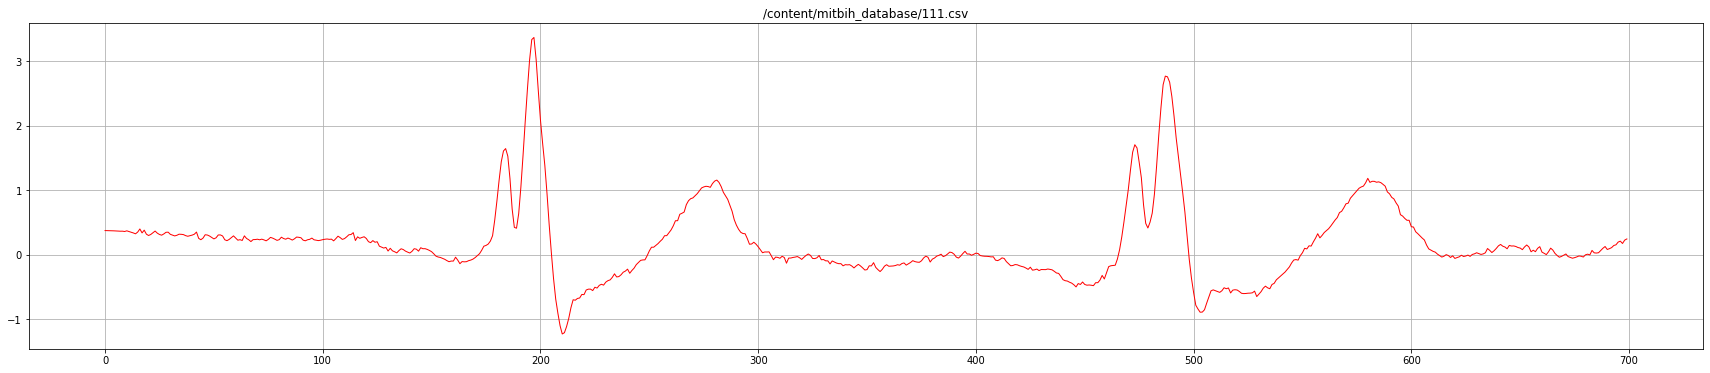

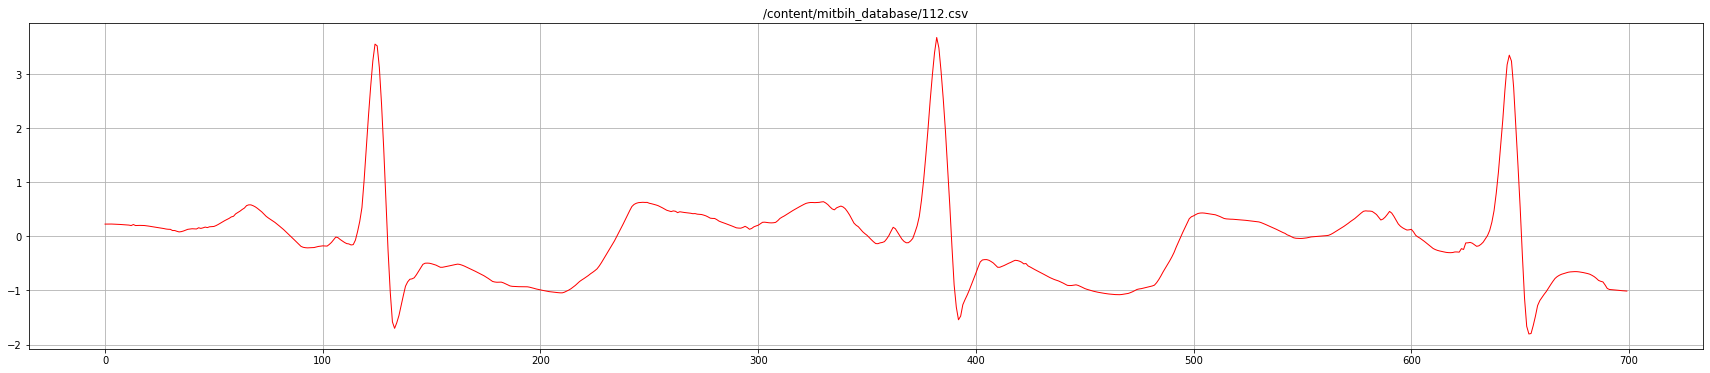

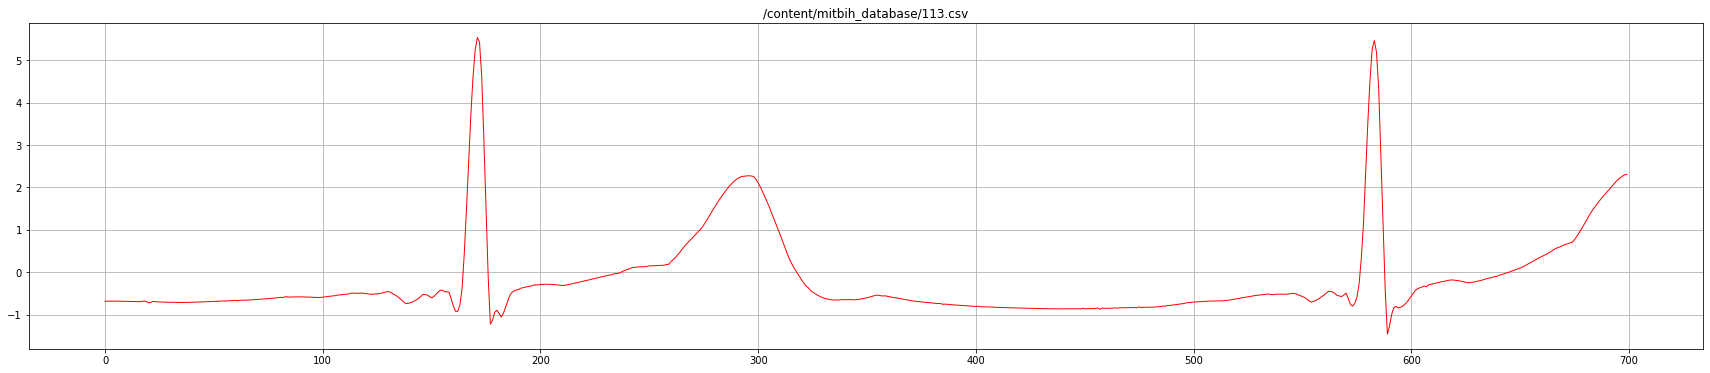

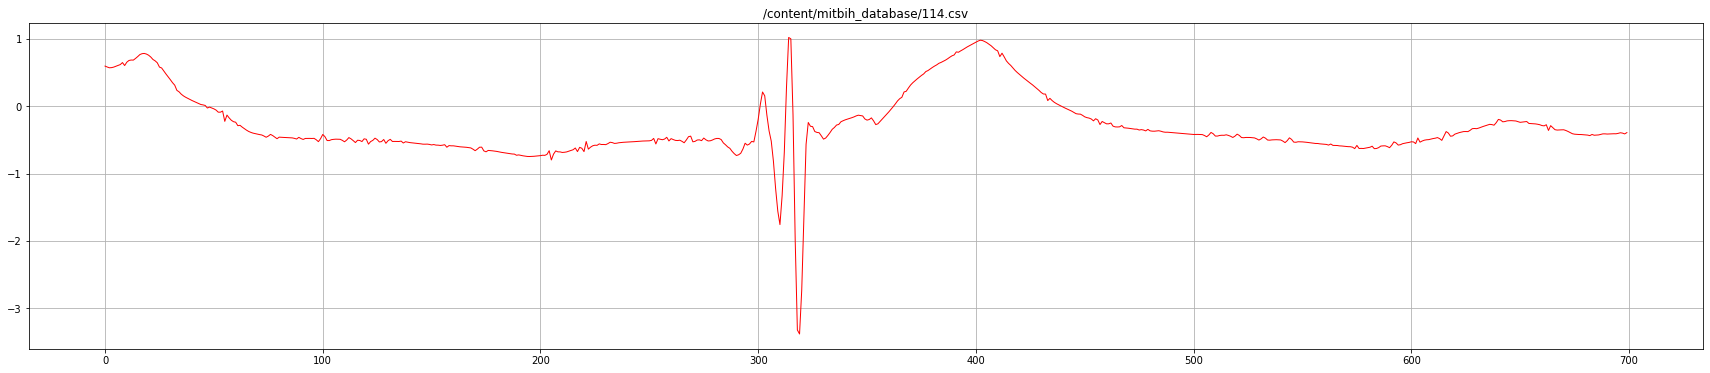

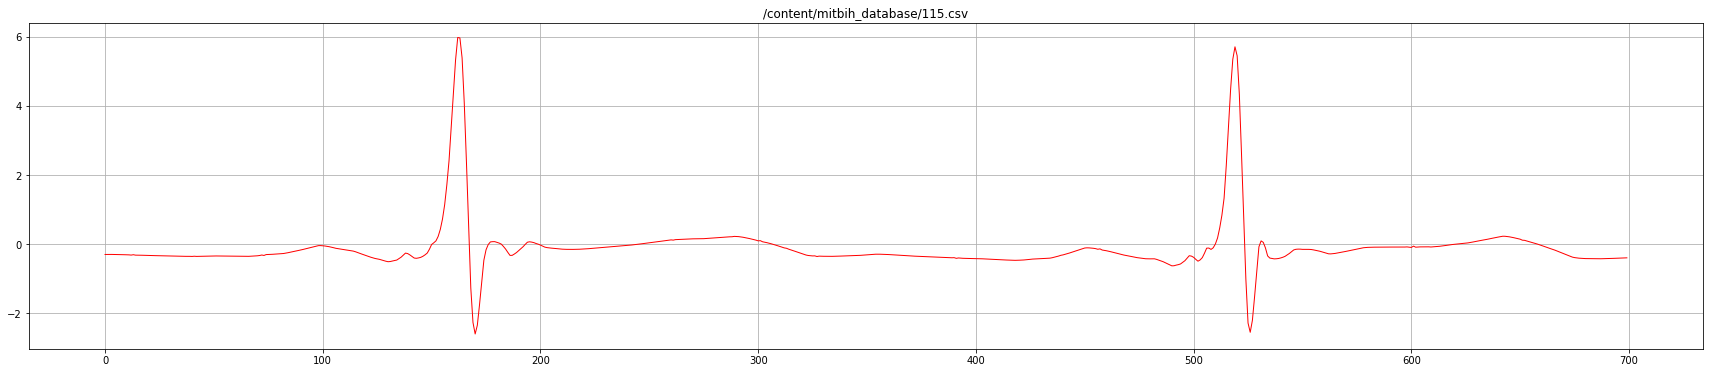

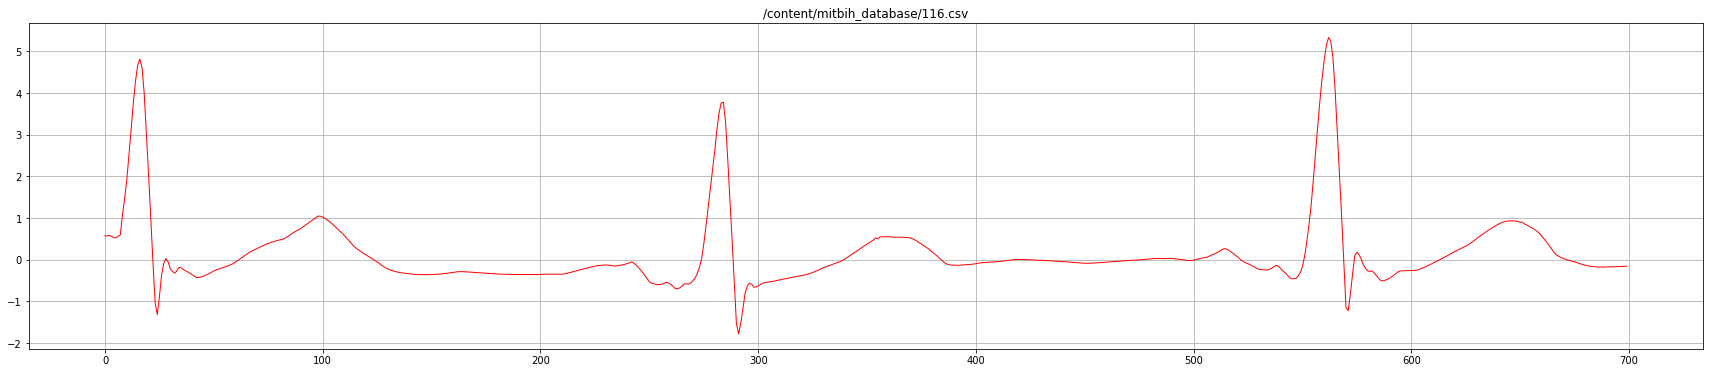

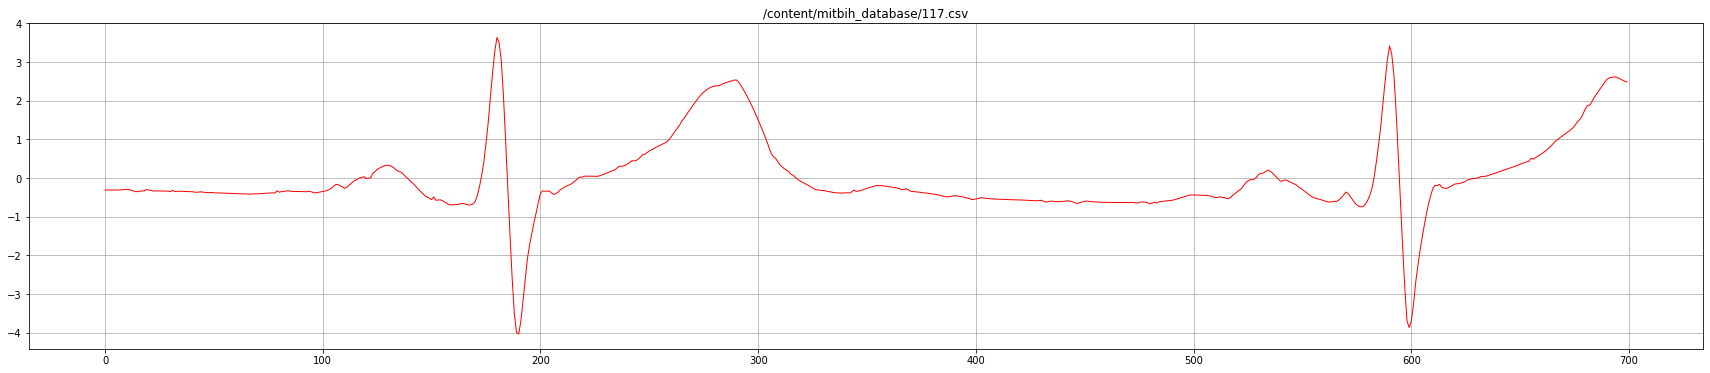

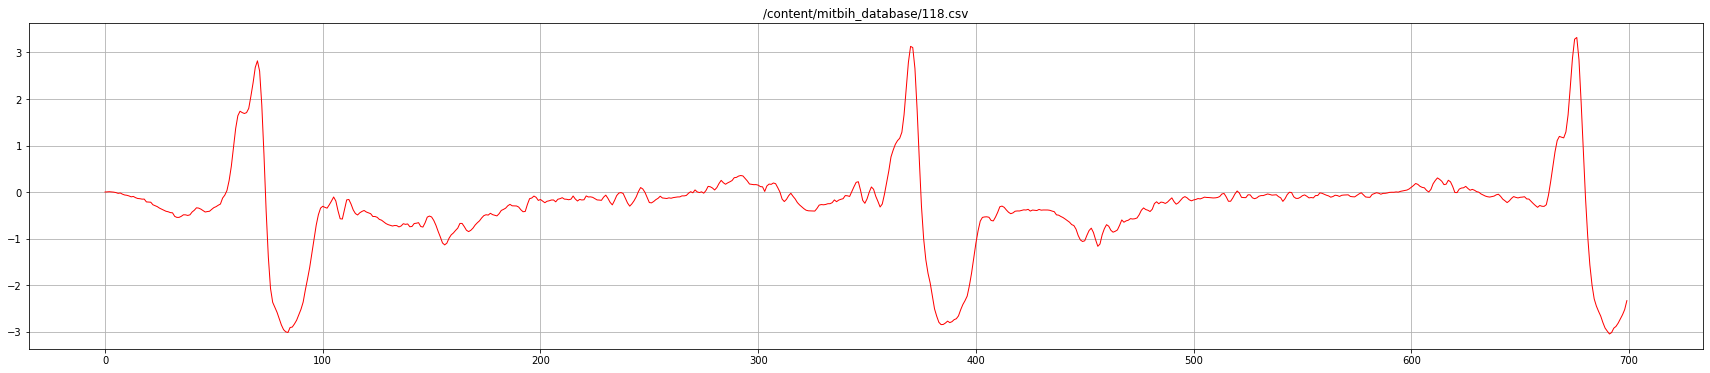

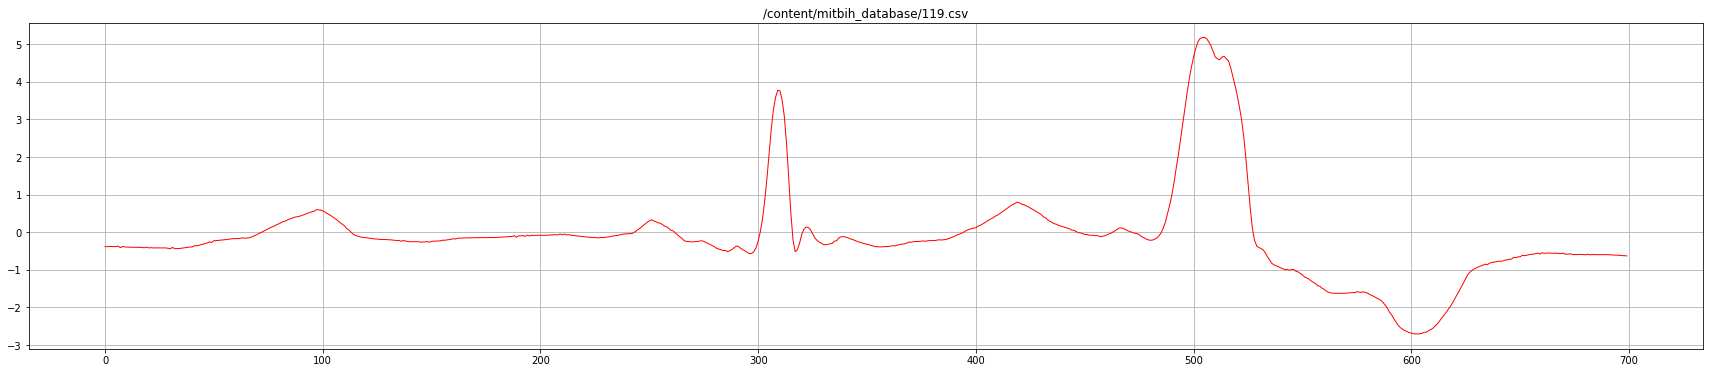

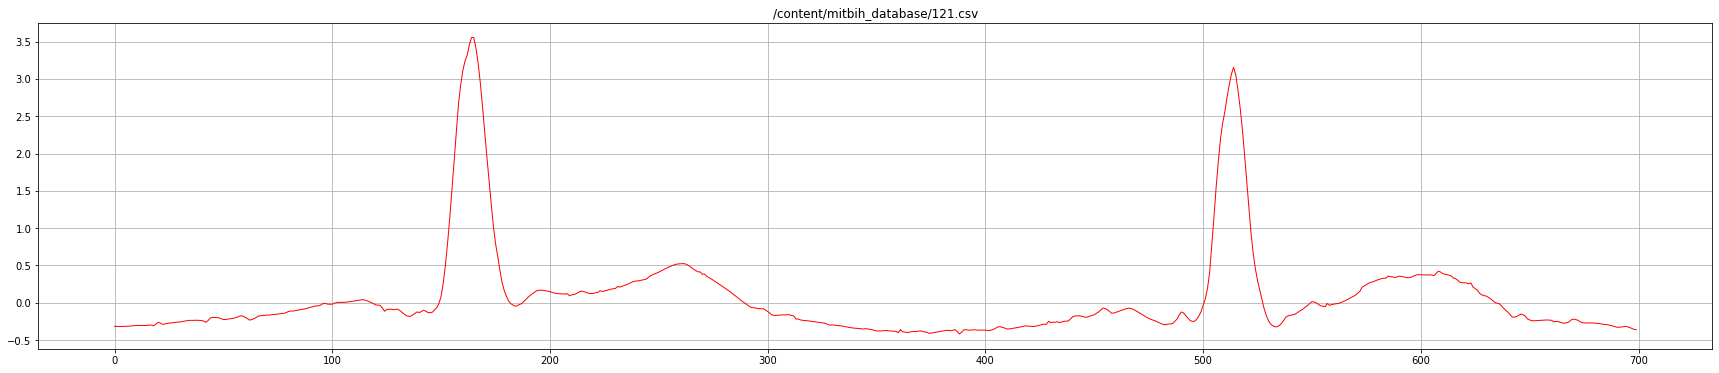

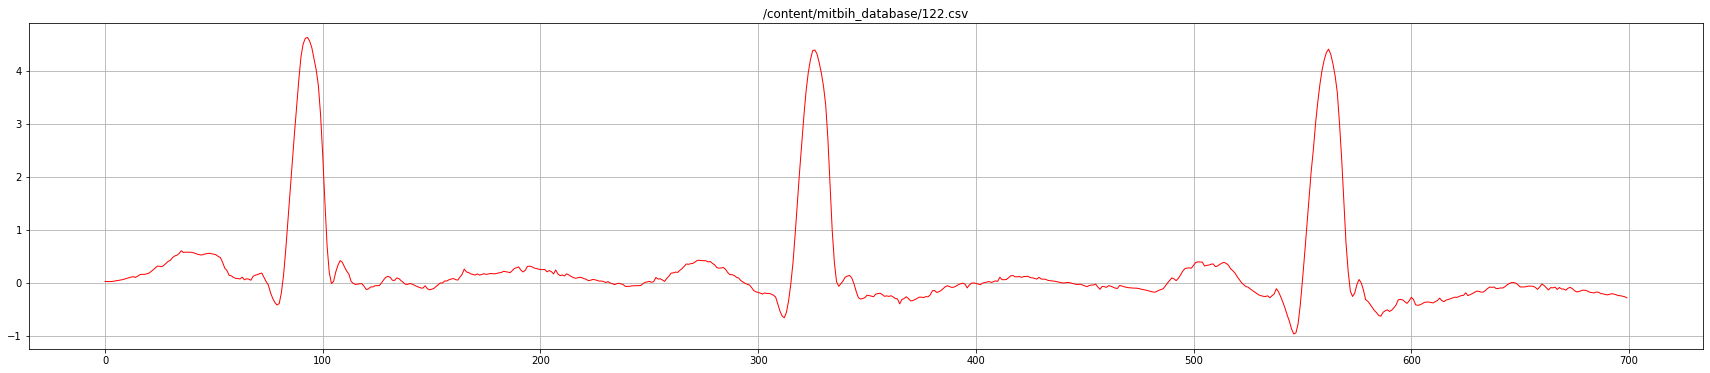

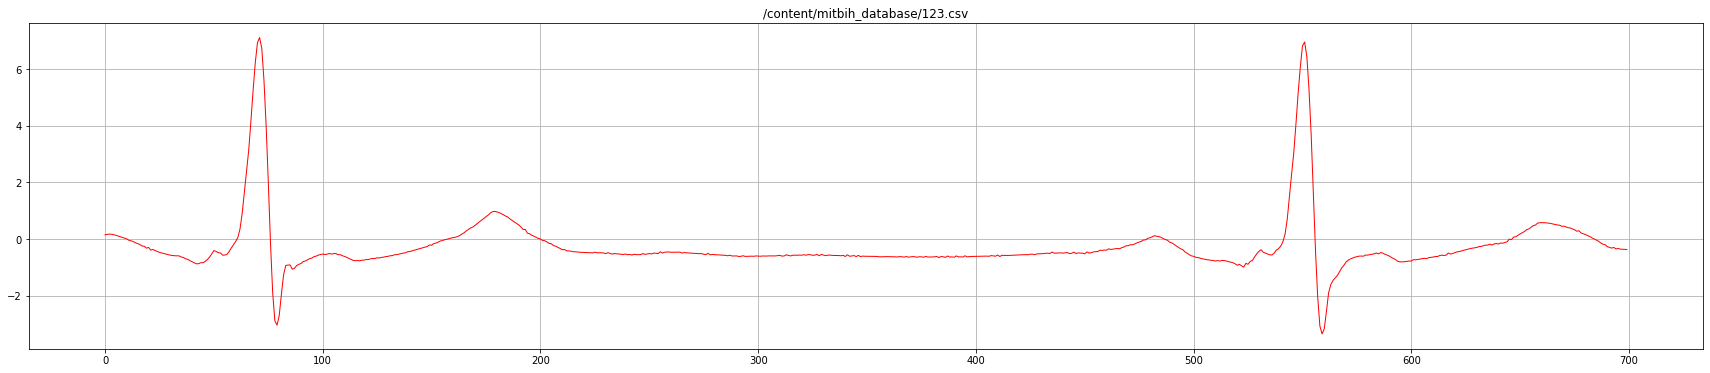

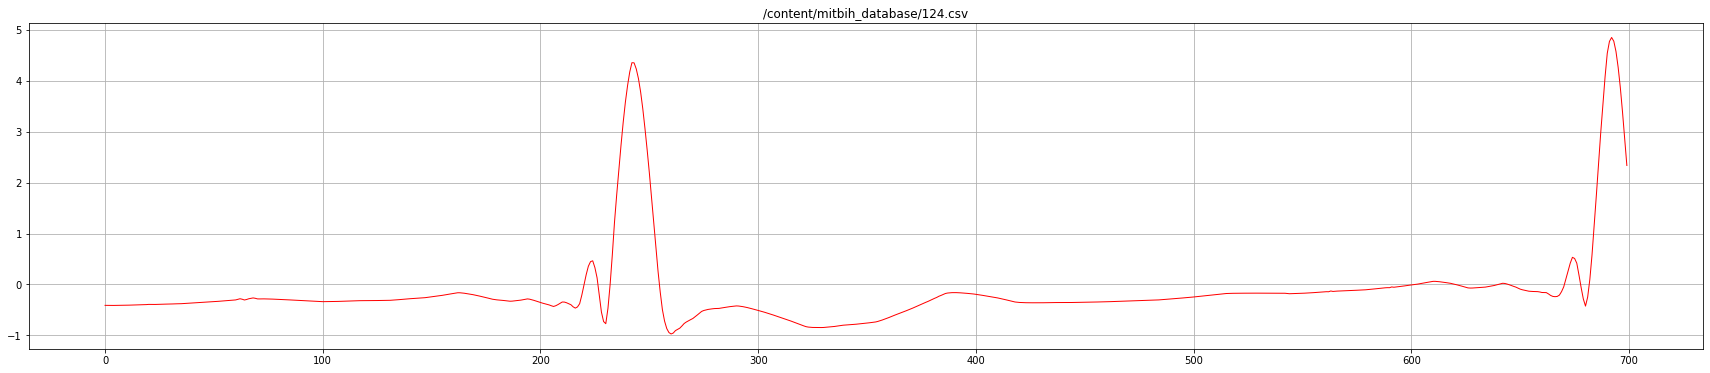

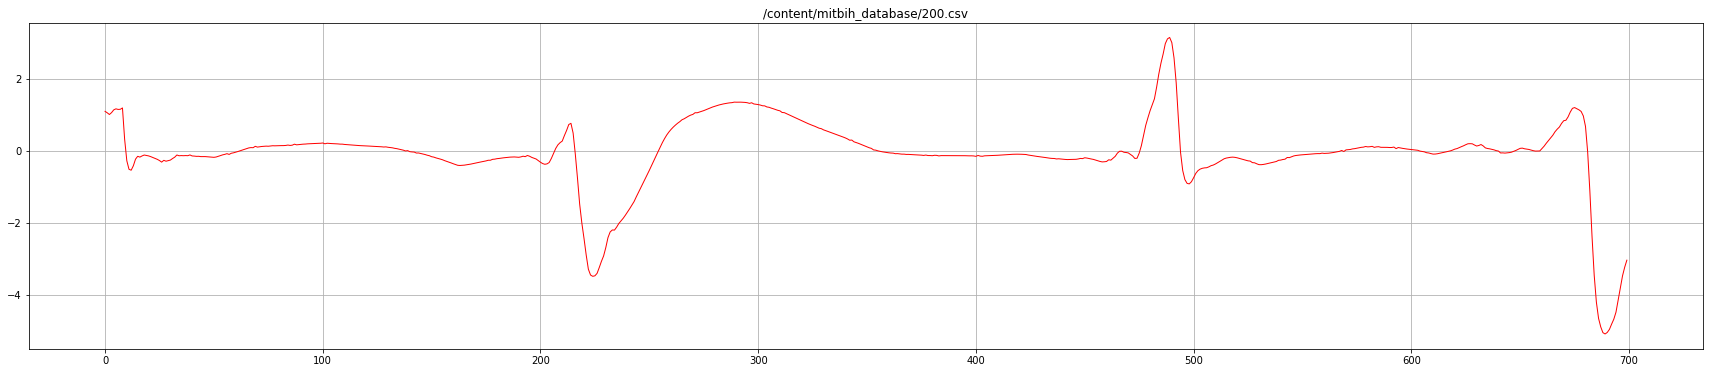

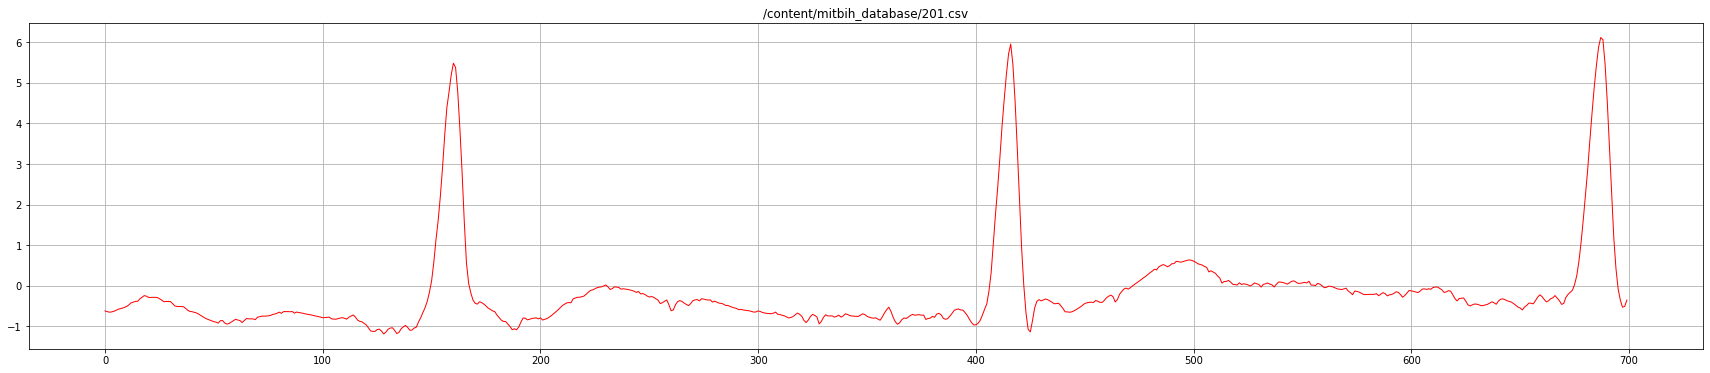

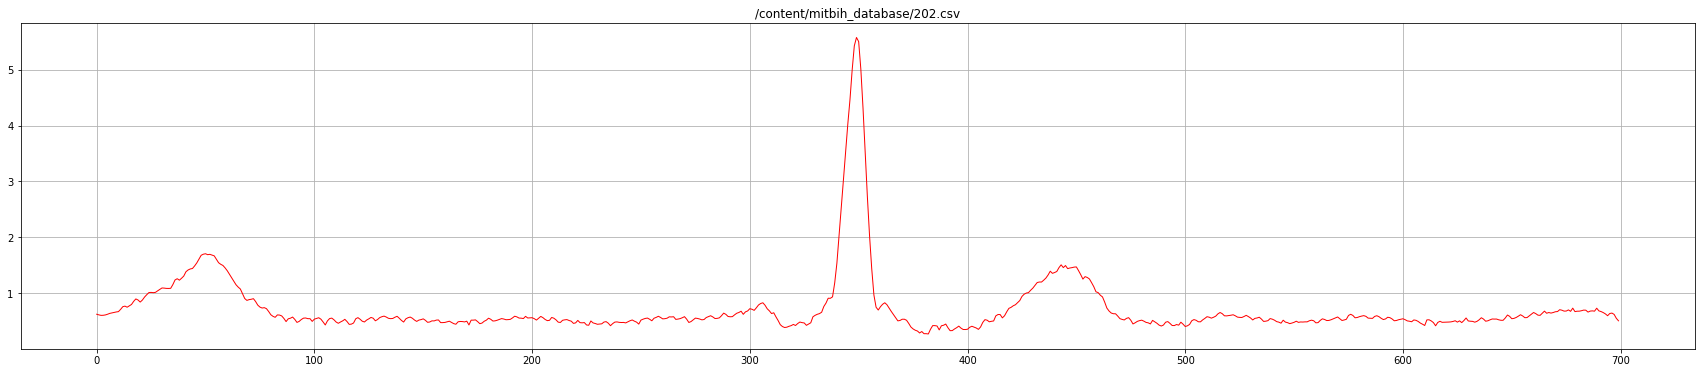

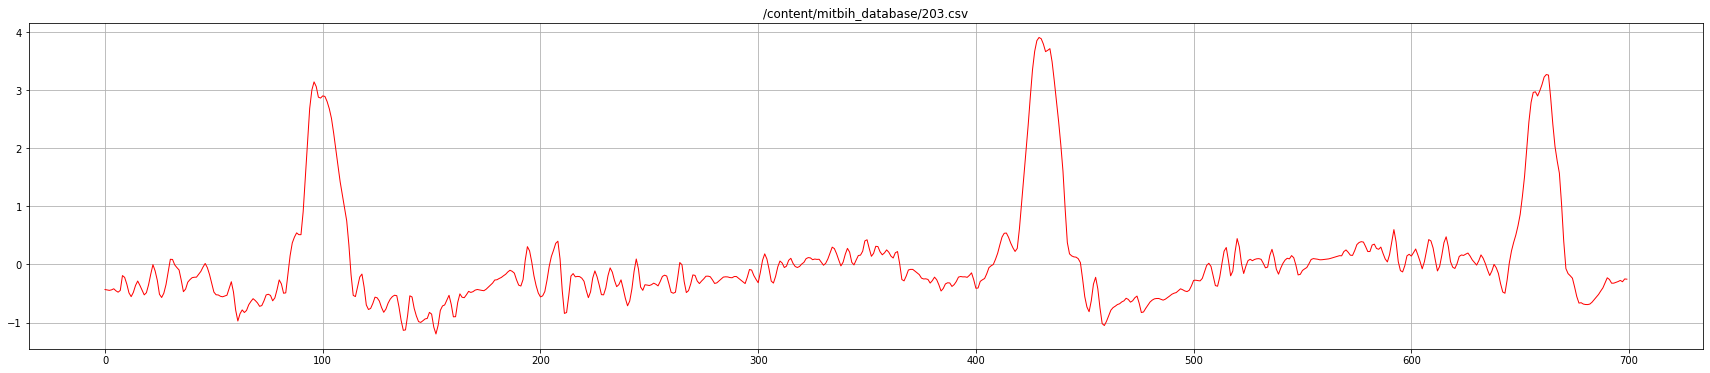

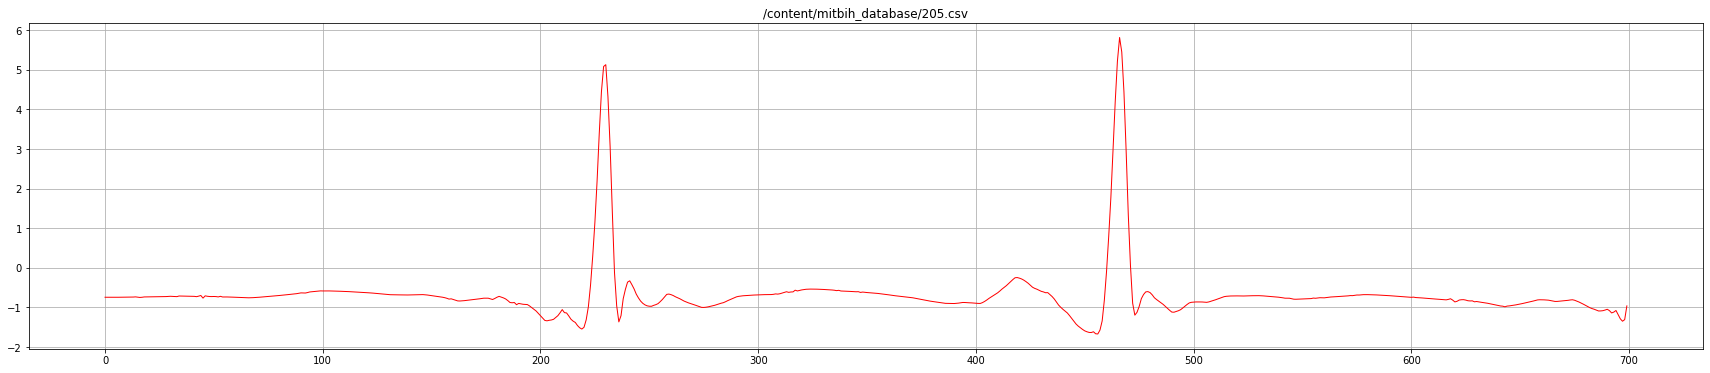

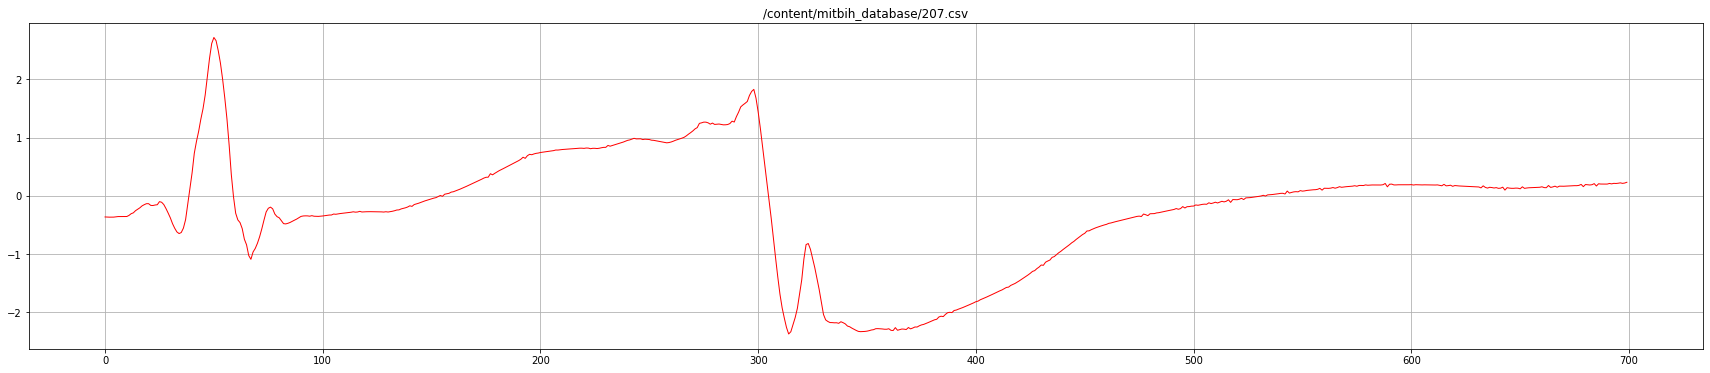

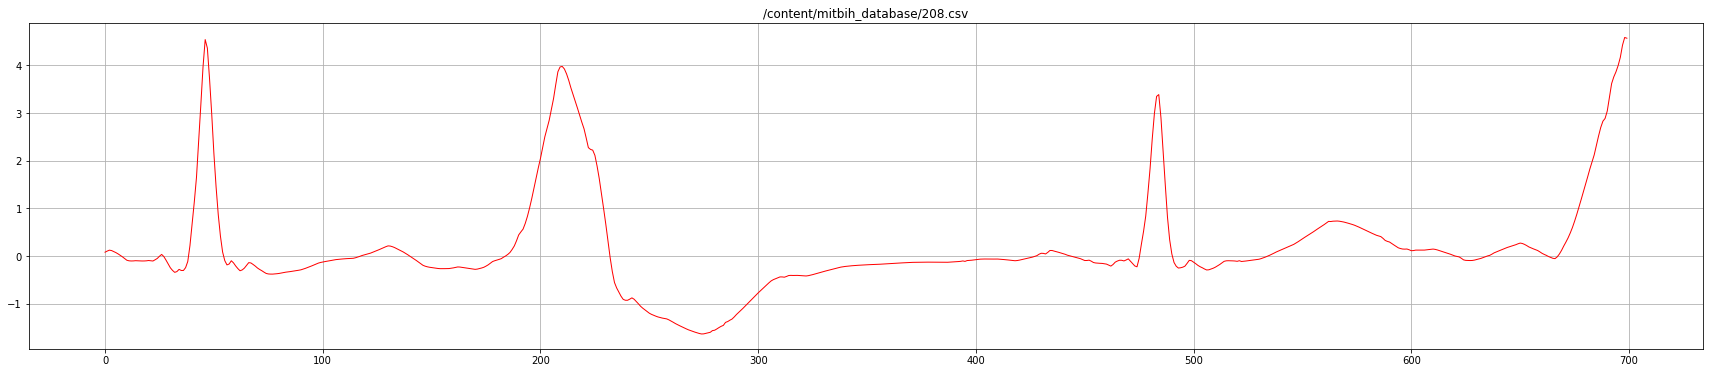

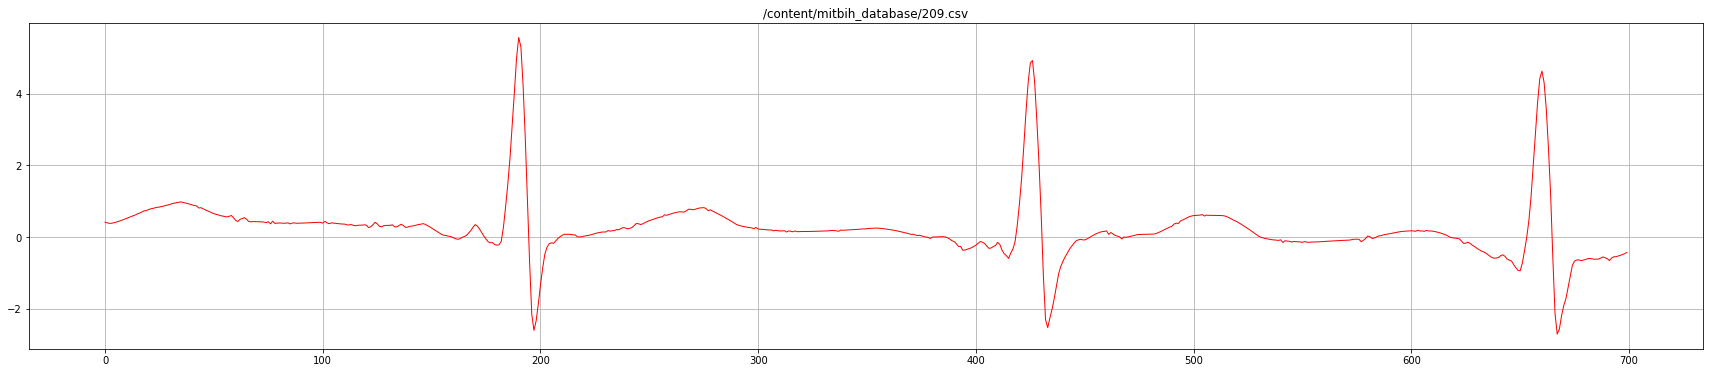

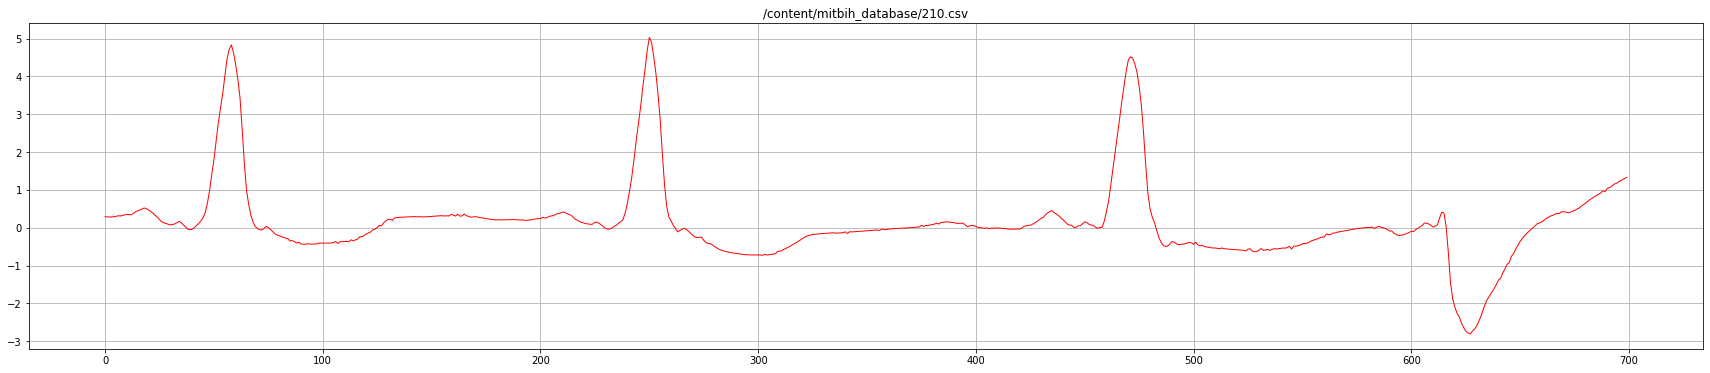

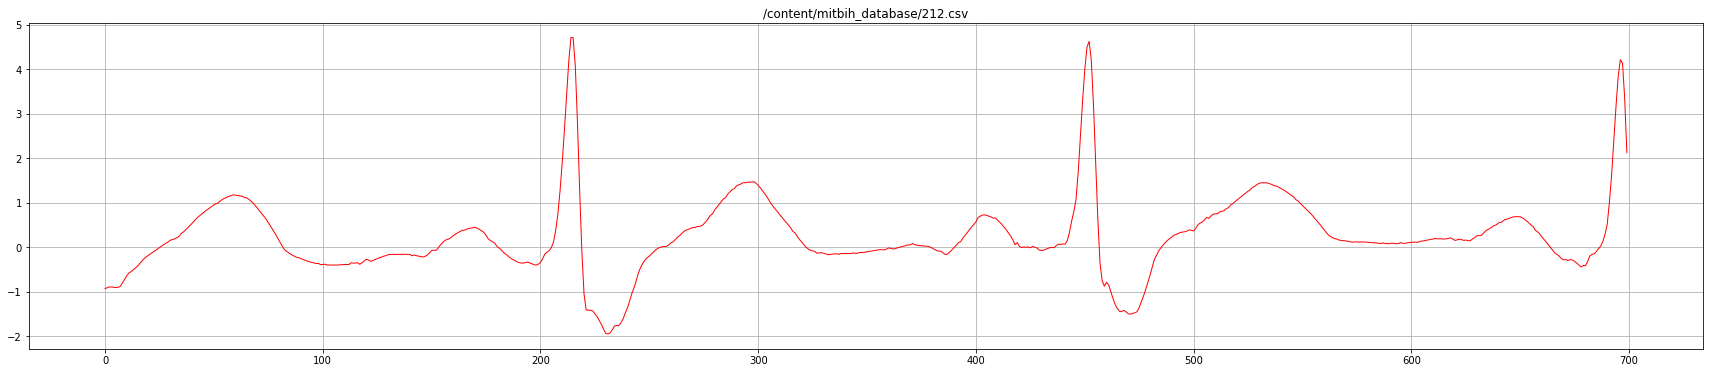

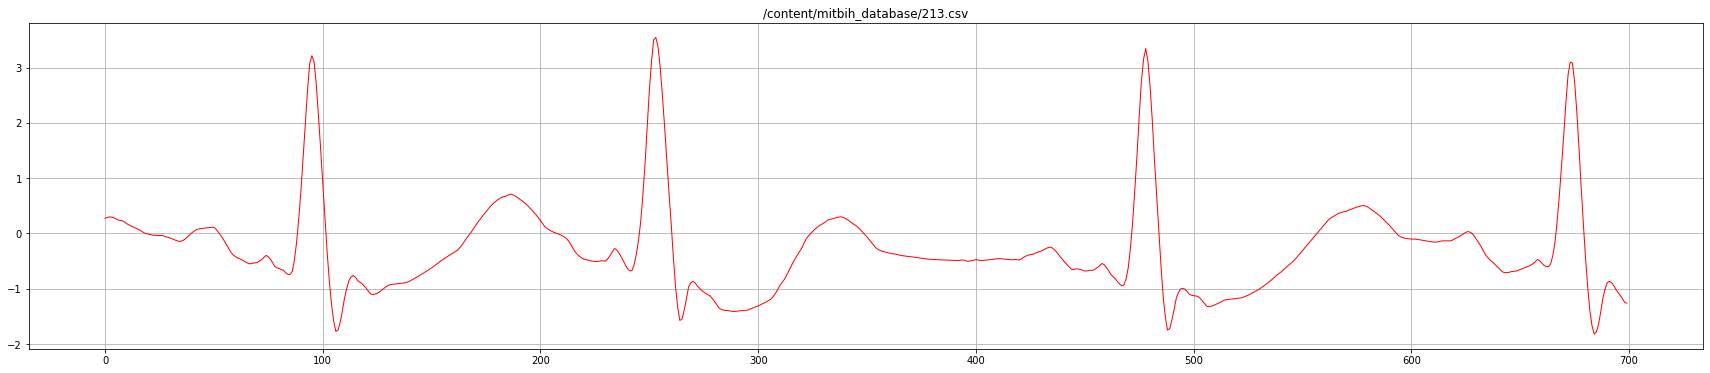

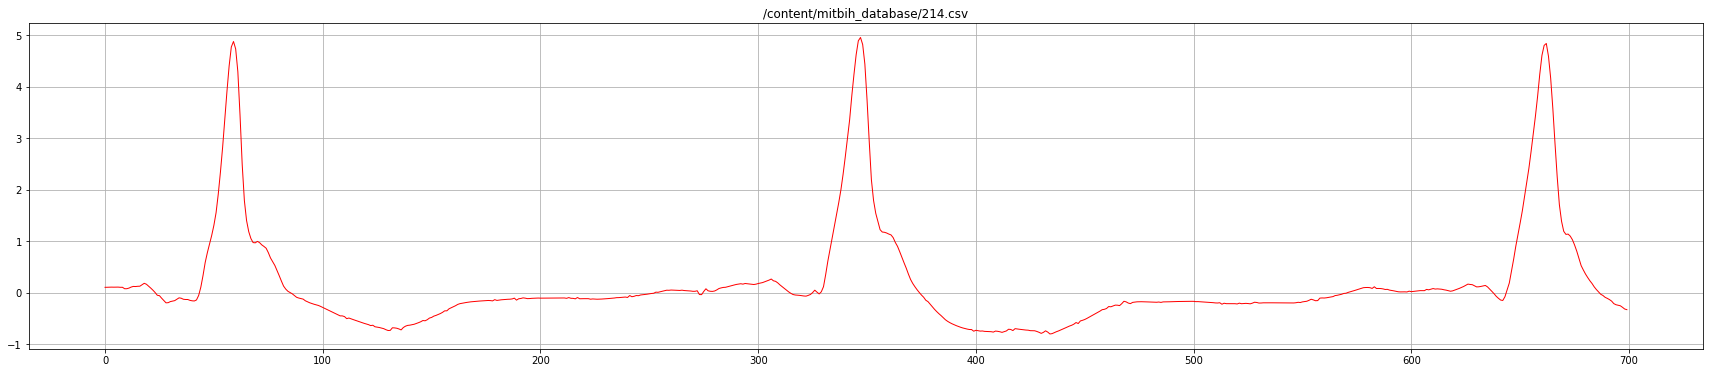

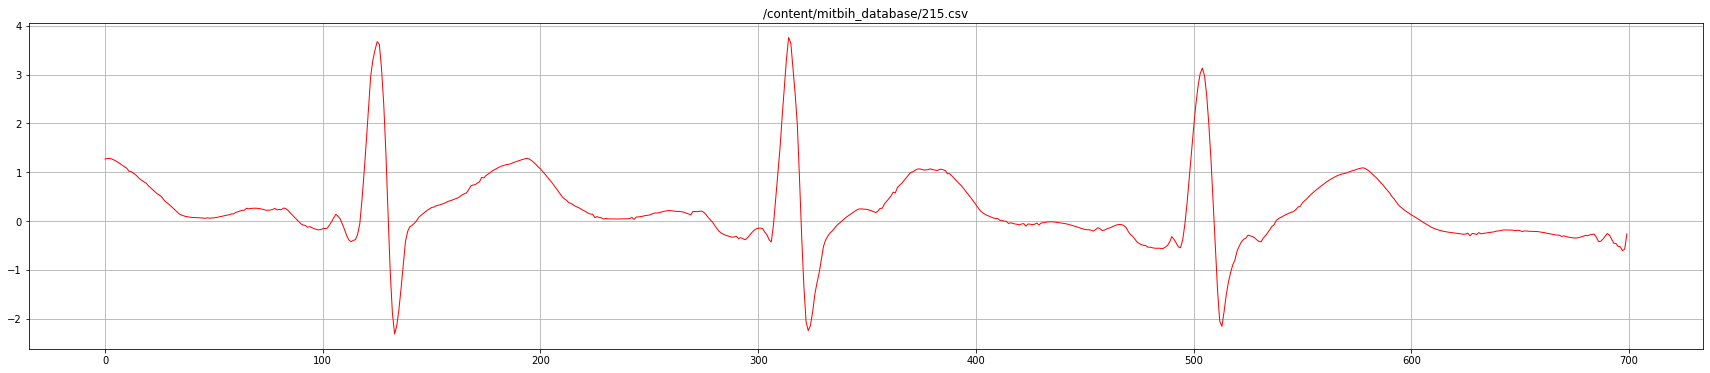

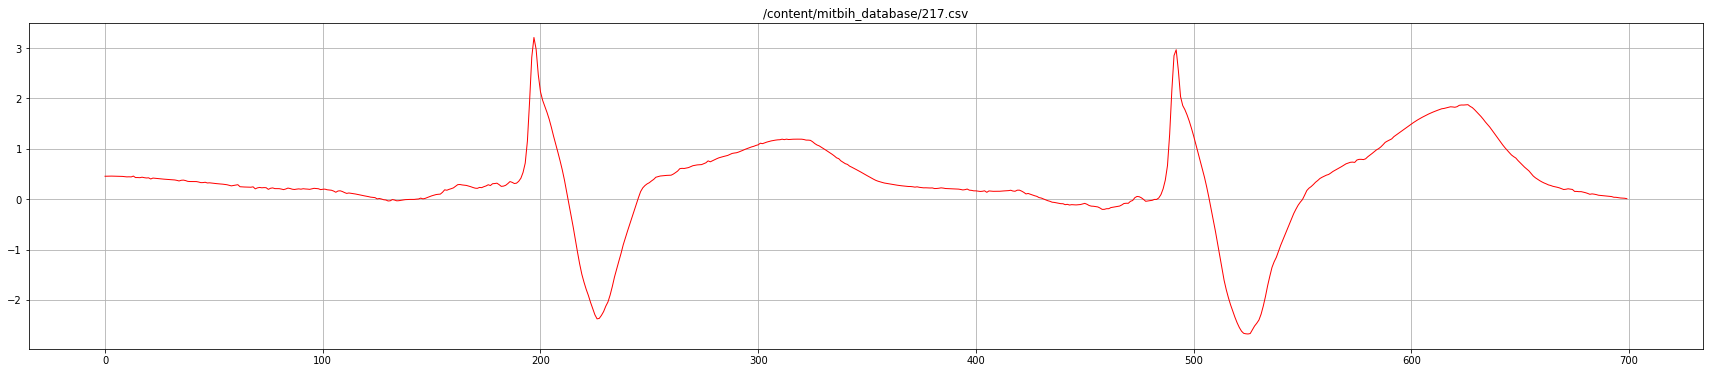

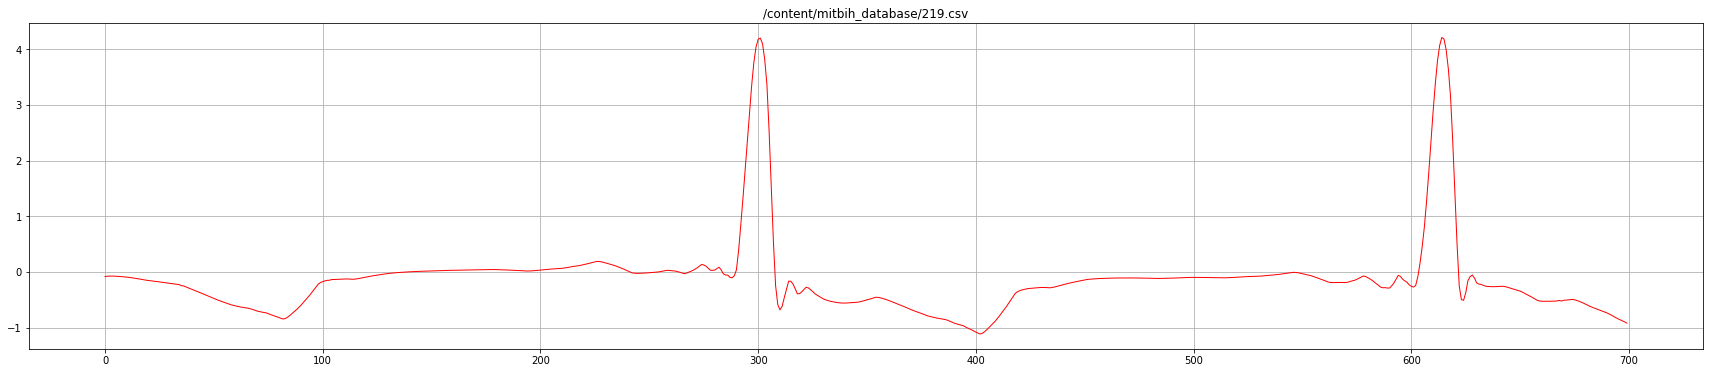

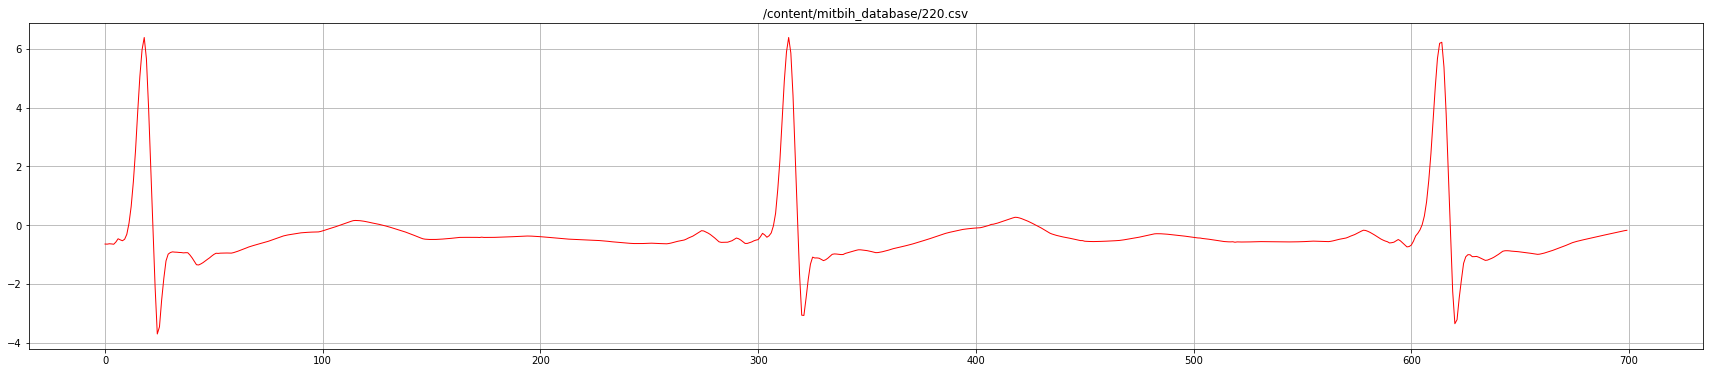

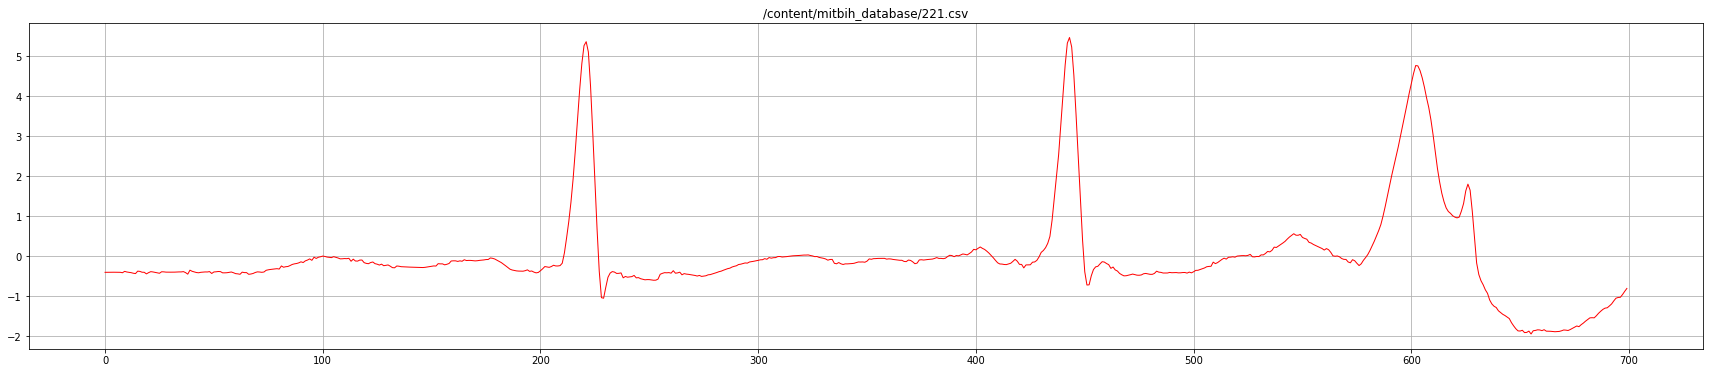

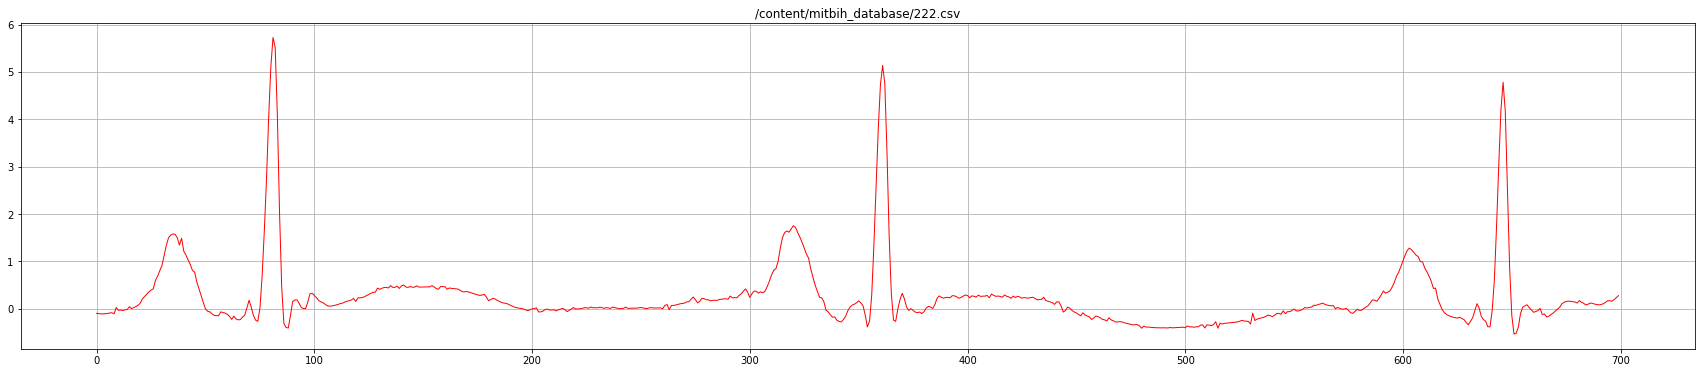

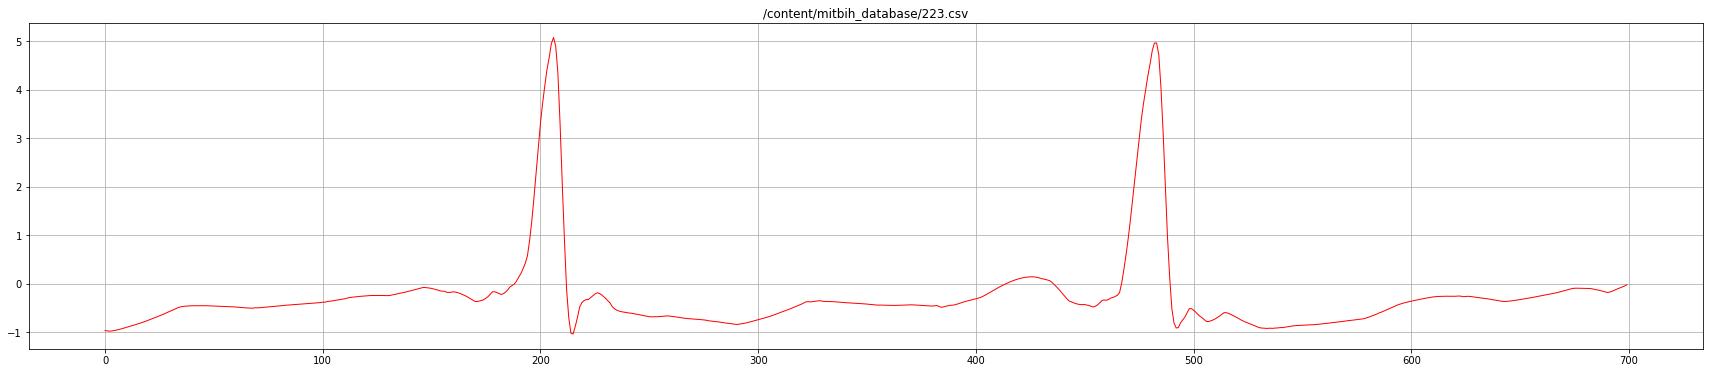

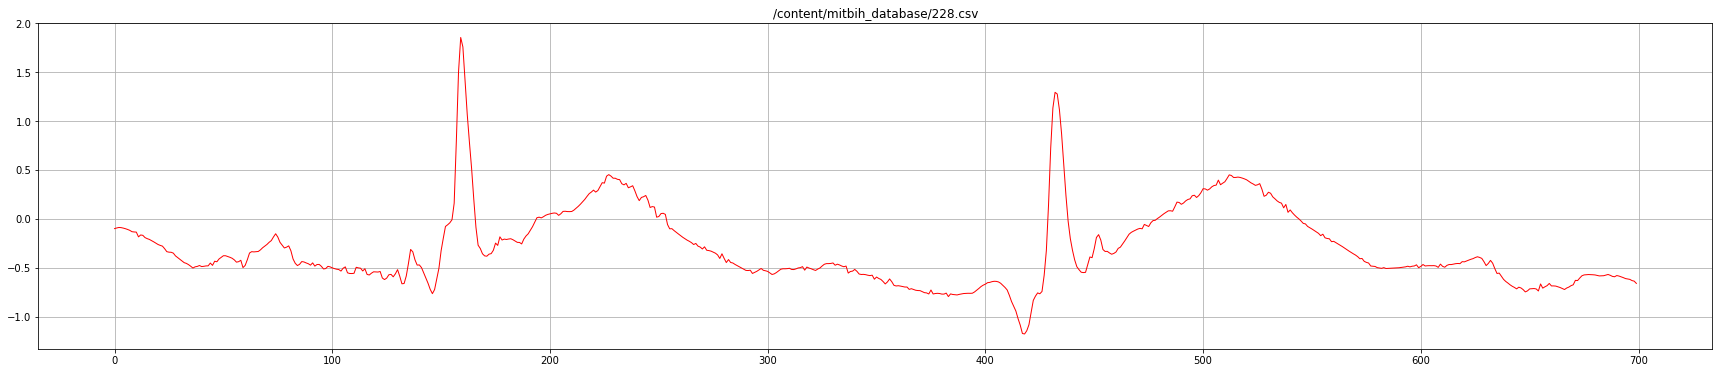

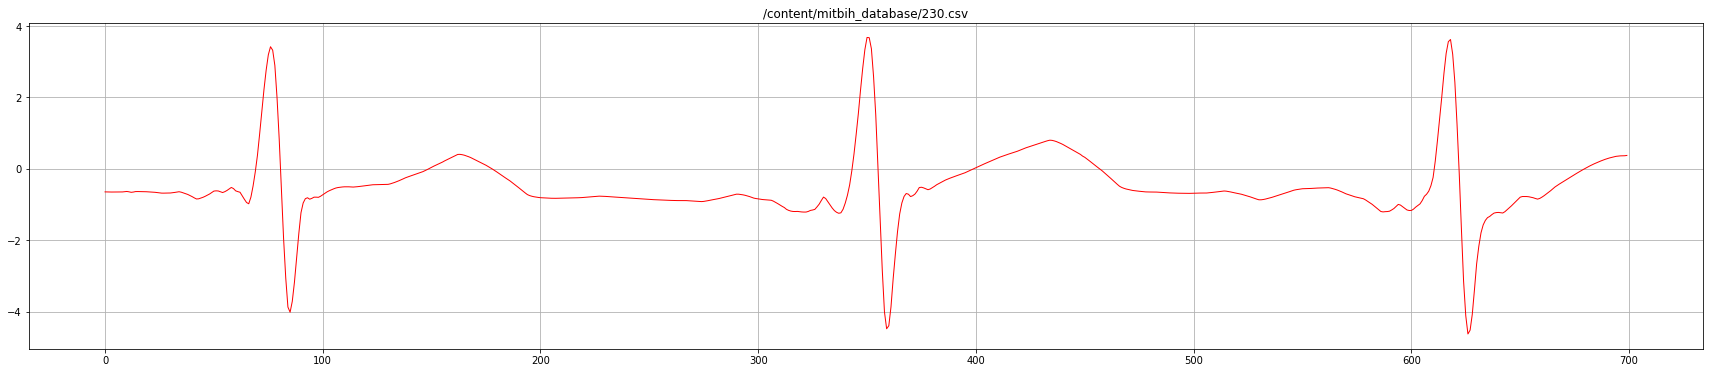

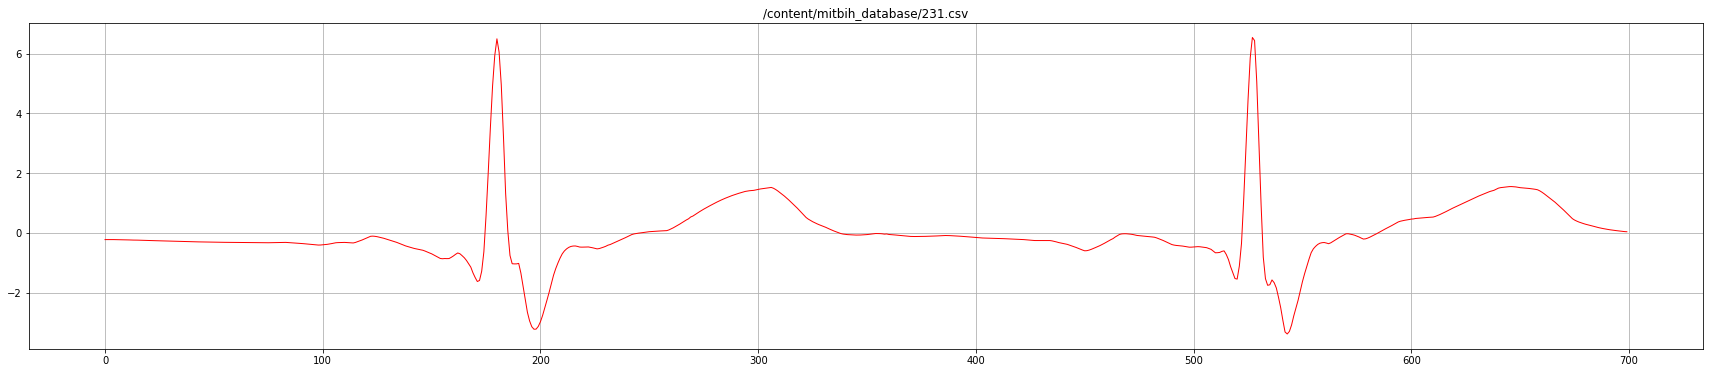

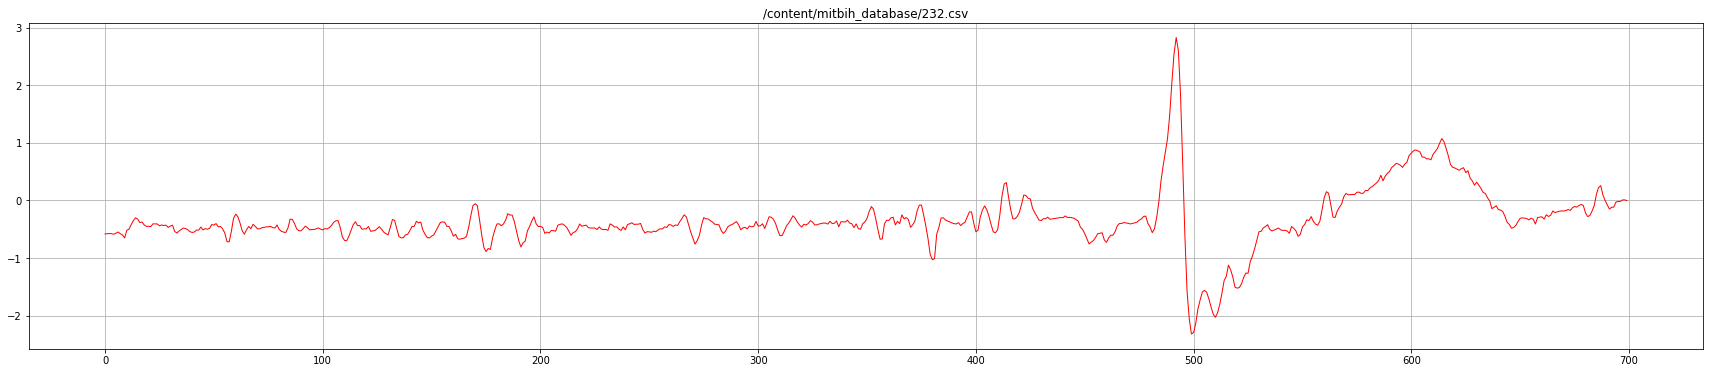

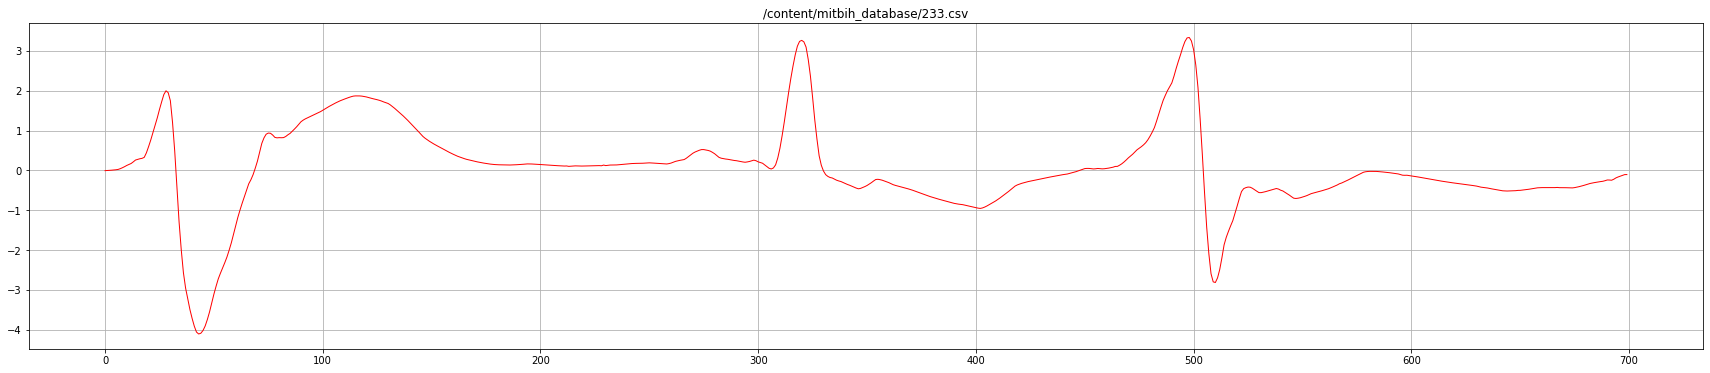

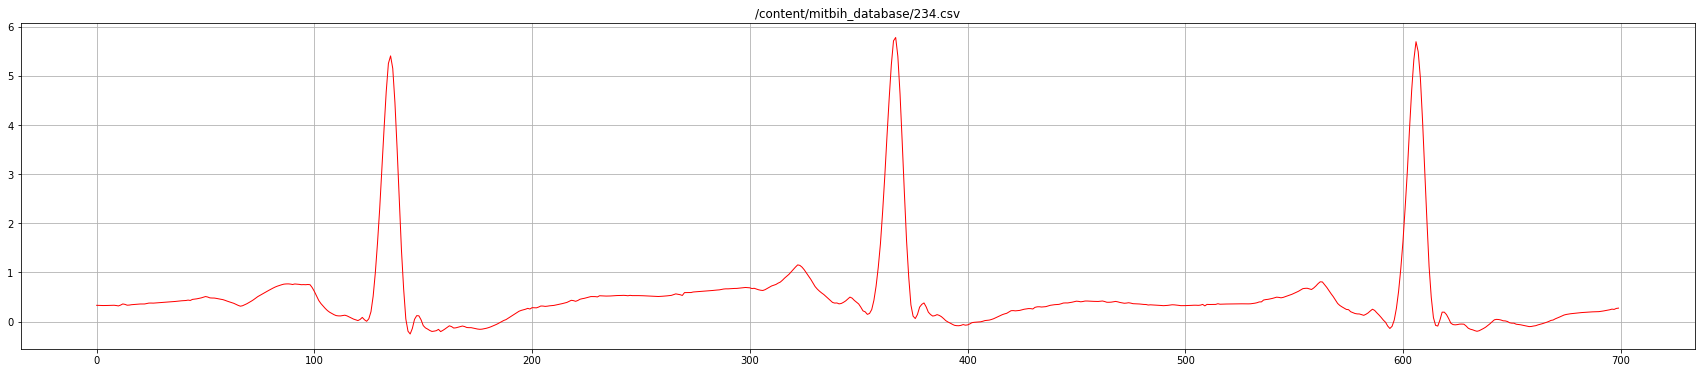

In [12]:
# reads signal data from csv files
for r in range(0,len(records)):
    signals = []
    with open(records[r], 'rt') as csvfile:
        x = csv.reader(csvfile, delimiter=',', quotechar='|') 
        row_index = -1
        for row in x:
            if(row_index >= 0):
              signals.insert(row_index, int(row[1]))
            row_index += 1
    signals = denoise(signals)
    signals = stats.zscore(signals)
    plt.title(records[r])
    plt.plot(signals[0:700])
    plt.show()

In [13]:
X = list()
y = list()
classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

In [16]:
# extract beats and arrythmia type from annotations
for r in range(0,len(records)):
  with open(annotations[r], 'r') as ann:
    data = ann.readlines() 
    beats = list()
    for d in range(1, len(data)):
      splitted = data[d].split(' ')
      splitted = filter(None, splitted)
      next(splitted) 
      pos = int(next(splitted))
      arrhythmia_type = next(splitted)
      if(arrhythmia_type in classes):
        arrhythmia_index = classes.index(arrhythmia_type)
        count_classes[arrhythmia_index] += 1
        if(180 <= pos and pos < (len(signals) - 180)):
          beats = signals[pos-180:pos+180] 
          X.append(beats)
          y.append(arrhythmia_index)

for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

## Class Representation

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


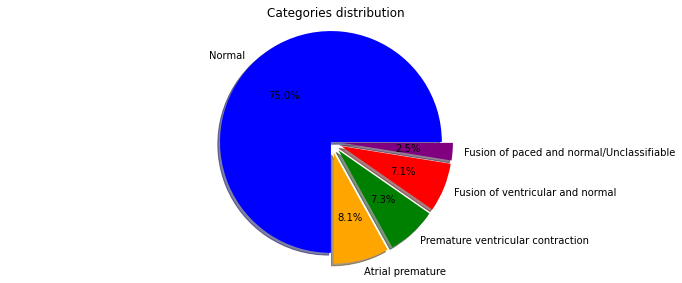

In [36]:
X_dataFrame= pd.DataFrame(X)
class_ctr = X_dataFrame[X_dataFrame.shape[1]-1].value_counts()
print(class_ctr)
classes = {0: 'Normal', 1: 'Atrial premature', 2: 'Premature ventricular contraction', 
           3: 'Fusion of ventricular and normal', 4: 'Fusion of paced and normal/Unclassifiable'}
col = ['blue', 'orange', 'green', 'red', 'purple']
fig1, ax1 = plt.subplots(figsize = (10,4))
ax1.pie(class_ctr, explode = (0, 0.1, 0.1, 0.1, 0.1) ,
         labels = [classes[i] for i in range(5)] ,colors=col, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set_title('Categories distribution')
plt.tight_layout()
plt.show()

